# Intrinsic Camera Calibration of GoPro with OpenCV ChAruCo pattern

### Goal

The goal of this notebook is to calibrate the intrinsic parameter $K$ of the camera.  Given a number of chessboard (charuco) images, this notebook first detects the corner positions in each image, and then finds the camera pose of each frame and the camera intrinsic parameters.

* Input:  $n$ chessboard images (= the 2D corner position $x$ and the corresponding 3D position $X$ in the world (chessboard) coordinate system)
* Output: intrinsic parameter $K$, distortion coefficients $d$, $n$ camera poses $R_i, t_i$ w.r.t. the chessboard

To have a better / robust estimation of $K$, the chessboard should be captured as large as possible in the DoF in different poses.


Notice:
* The chessboard coordinate system serves as the world coordinate system.
* Though we obtain $R, t$ as a result, we are not interested in them in this scenario.


### Projection model

Please check the OpenCV document for the detail. 
* https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#details

In short, a 3D point $X$ in the world coordinate system (WCS) is transformed to the camera coordinate system (CCS) by a roation $R$ and a translation $t$, and then projected to $x$ by $K$:
\begin{equation}
\tilde{x} \sim K \begin{bmatrix}
R \: | \: t
\end{bmatrix}
\tilde{X}.
\end{equation}


## Libraries

In [1]:

import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pycalib.plot import plotCamera
from pycalib.calib import distort_points


## Calibration parameters

**Important**
* Compare the pattern shown below with the pattern captured in the image.
* The numbers of rows and cols indicate **the numbers of CELLs, not corners**.
  * For example, an 18x9 ChAruco board has a 18 cells == 17 corners by 9 cells == 8 corners pattern.
  * In the case of the traditional chessboard, the rows and cols indicate the numbers of corners.

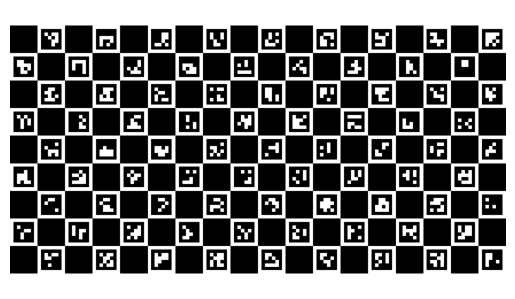

In [2]:
# Chessboard configuration

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard((18, 9), 0.02, 0.015, aruco_dict)

# check if the board is correct
image = board.generateImage((1280, 720))

plt.figure()
plt.imshow(image, cmap='gray')
#plt.title('DICT_4X4_250 6x5 ChAruco pattern')
plt.axis('off')
plt.show()

# Input images capturing the chessboard above
input_files = '../data/charuco/*.jpg'

## 2D corner detection

../data/charuco/00000001.jpg  found 136 corners
../data/charuco/00000002.jpg  found 136 corners
../data/charuco/00000003.jpg  found 136 corners
../data/charuco/00000004.jpg  found 136 corners
../data/charuco/00000005.jpg  found 136 corners
../data/charuco/00000006.jpg  found 136 corners
../data/charuco/00000007.jpg  found 136 corners
../data/charuco/00000008.jpg  found 136 corners
../data/charuco/00000009.jpg  found 136 corners
(9, 136, 1, 3) (9, 136, 1, 2)


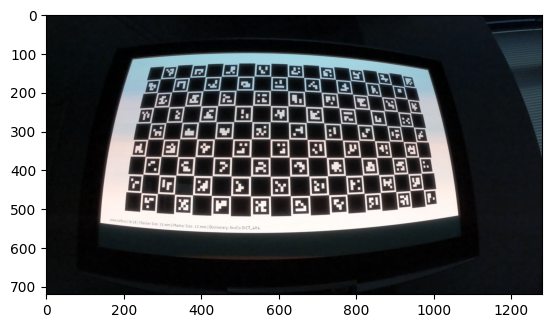

In [3]:
parameters =  cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR
detector = cv2.aruco.CharucoDetector(board, detectorParams=parameters)

all_obj_pts = []
all_img_pts = []
all_ids = []

for i in sorted(glob(input_files)):
    frame = cv2.imread(i)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    c_corners, c_ids, corners, ids = detector.detectBoard(gray)
    ret = len(c_corners)
    print(f'{i}  found {ret} corners')
    if ret > 0:
        objPoints, imgPoints = board.matchImagePoints(c_corners, c_ids)
        all_obj_pts.append(objPoints)
        all_img_pts.append(imgPoints)
        all_ids.append(c_ids)

    imsize = (gray.shape[1], gray.shape[0])

all_obj_pts = np.array(all_obj_pts)
all_img_pts = np.array(all_img_pts)

print(all_obj_pts.shape, all_img_pts.shape)

# show sample image
plt.figure()
plt.imshow(frame)
plt.show()

## Calibration

In [4]:

#ret, K, d, rvec, tvec = cv2.aruco.calibrateCameraCharuco(all_corners, all_ids, board, imsize, None, None,
#                                                         flags=cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_RATIONAL_MODEL)

# Remove cv2.CALIB_RATIONAL_MODEL for non-fisheye lens

ret, K, d, rvec, tvec = cv2.calibrateCamera(all_obj_pts, all_img_pts, imsize, None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_RATIONAL_MODEL)

print("Image size = ", imsize)
print("Reprojection error = ", ret)
print("Intrinsic parameter K = ", K)
print("Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) = ", d)

for i in range(len(d[0])):
    if np.abs(d[0][i]) > 1:
        print(f'[WARN] distCoeffs[{i}] is too large: {d[0][i]}.  Possibly an overfitting.')

assert ret < 1.0


Image size =  (1280, 720)
Reprojection error =  0.3010951580606194
Intrinsic parameter K =  [[586.82908524   0.         641.01812808]
 [  0.         586.82908524 356.16960629]
 [  0.           0.           1.        ]]
Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) =  [[ 5.70126130e-01 -5.70435346e-01  3.89275117e-04 -5.89263800e-04
  -4.88942040e-02  8.65418192e-01 -5.13053770e-01 -1.78884281e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


## Verification

To examine if your intrinsic calibration is reliable, we can

1. check if straight lines appear as straight in the undistorted image,
2. check the scale of the distortion coefficients,
3. compare calibration results with and without `cv2.CALIB_FIX_ASPECT_RATIO` flag, and
4. do a cross validation (e.g., leave-one-out).

### Scale of distortion coefficients

In short, distortion parameters larger than 1 would be a sign of calibration failure.

As described in [OpenCV](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html), the lens distortion modifies the pixel positions in the *normalized* camera coordinate system.  Since the normalized camera coordinate is defined as

$$ \begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} = K^{-1} \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}\,, $$

to normalize the focal length to be $1$, the range of $(x', y')$ can be given as a function of FoV as follows (f are roughly converted 35 mm equivalent focal lengths).

| FoV        | $15^\circ$ <br> f=135mm| $30^\circ$ <br> f=70mm | $60^\circ$ <br> f=30mm| $90^\circ$ <br> f=18mm | $120^\circ$ <br> f=10mm | $150^\circ$ <br> f=3mm |
|------------|------------|------------|------------|------------|-------------|-------------|
| $(x', y')$ | $\pm 0.13$ | $\pm 0.27$ | $\pm 0.58$ | $\pm 1.00$ | $\pm 1.73$  | $\pm 3.73$  |

Consider a simplified lens distortion model where only $k_1$ is active:

$$ \begin{bmatrix} x'' \\ y'' \end{bmatrix} = \begin{bmatrix} x' \\ y' \end{bmatrix} + k_1 (x'^2 + y'^2) \begin{bmatrix} 1 \\ 1 \end{bmatrix}\,, $$

where $x', y'$ are the ideal positions in the normalized camera and $x''$ and $y''$ are their distorted positions.  In case of $k_1 = 1$, $(x'', y'')$ ranges as follows.

| FoV        | $15^\circ$ | $30^\circ$ | $60^\circ$ | $90^\circ$ | $120^\circ$ | $150^\circ$ |
|------------|------------|------------|------------|------------|-------------|-------------|
| $(x', y')$ | $\pm 0.13$ | $\pm 0.27$ | $\pm 0.58$ | $\pm 1.00$ | $\pm 1.73$  | $\pm 3.73$  |
| $(x'', y'')$ | $\pm 0.17$ | $\pm 0.41$ | $\pm 1.24$ | $\pm 3.00$ | $\pm 7.73$  | $\pm 31.6$  |

We can also compute the position $(x_m', y_m')$ which hits the image edge after the lens distortion and its ratio $\rho$ against the original $(x', y')$ as follows.

| FoV        | $15^\circ$ | $30^\circ$ | $60^\circ$ | $90^\circ$ | $120^\circ$ | $150^\circ$ |
|------------|------------|------------|------------|------------|-------------|-------------|
| $(x', y')$ | $\pm 0.13$ | $\pm 0.27$ | $\pm 0.58$ | $\pm 1.00$ | $\pm 1.73$  | $\pm 3.73$  |
| $(x'', y'')$ | $\pm 0.17$ | $\pm 0.41$ | $\pm 1.24$ | $\pm 3.00$ | $\pm 7.73$  | $\pm 31.6$  |
| $(x_m', y_m')$ | $\pm 0.11$ | $\pm 0.19$ | $\pm 0.34$ | $\pm 0.50$ | $\pm 0.71$  | $\pm 1.14$  |
| $\rho$ | $0.82$ | $0.72$ | $0.59$ | $0.50$ | $0.41$  | $0.31$  |

This indicates that only the central 50% of the image is used at $90^\circ$ FoV and $k_1 = 1$ after the lens distortion (if the distortion process does not change the image size).

In most cases, this is unlikely to happen.  Check the following cell to see how the estimated parameters distorts the image, and compare it with your image.

### Comparison of with and without `cv2.CALIB_FIX_ASPECT_RATIO` flag

If the results are not *consistent*, for example,

- the result without `cv2.CALIB_FIX_ASPECT_RATIO` flag can achieve a much smaller reprojection error, or
- the parameters `K` and / or `d` changed drastically,

the calibration is not reliable.  You can add more images (constraints) which observes the reference object from various positions.

### Cross varidation

Similary to the `cv2.CALIB_FIX_ASPECT_RATIO` flag test, you can leave some images for cross validation.  If the results are consistent regardless of the images to be excluded from the calibration, the result is considered as reliable.




/tmp/ipykernel_171754/160682757.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_171754/160682757.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_171754/160682757.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                        w/o          w/
reprojection error:     0.296188     0.301095
                fx:   589.013436   586.829085
                fy:   588.491216   586.829085
                u0:   641.414224   641.018128
                v0:   355.656781   356.169606
                k1:     0.550057     0.570126
                k2:    -0.556550    -0.570435
                p1:     0.000549     0.000389
                p2:    -0.000541    -0.000589
                k3:    -0.044677    -0.048894
                k4:     0.848314     0.865418
                k5:    -0.506729    -0.513054
                k6:    -0.169232    -0.178884


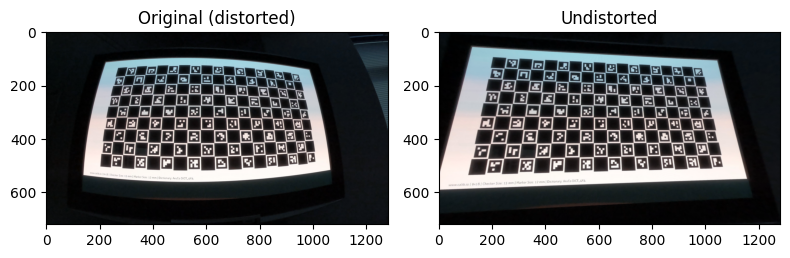

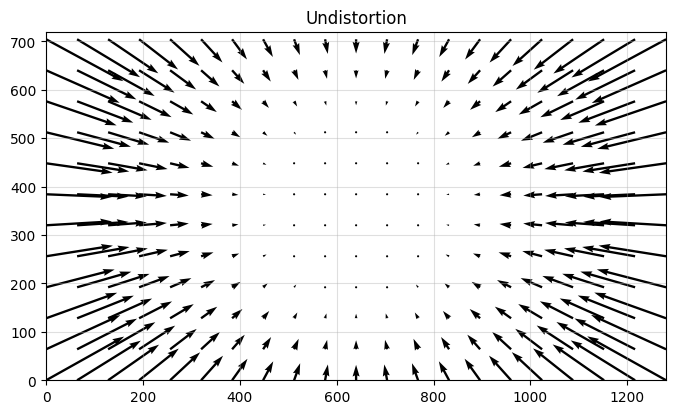

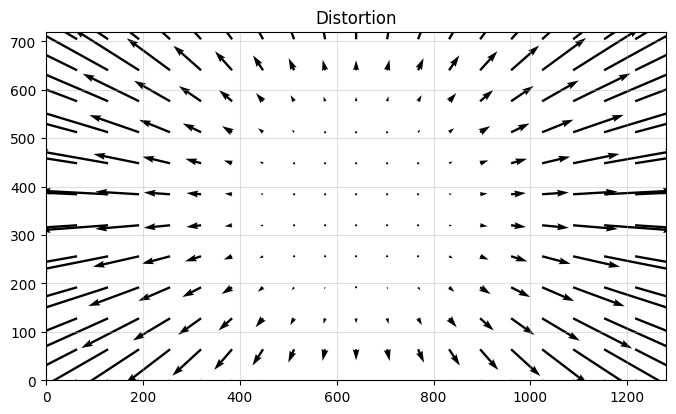

In [9]:
# check if straight lines appear as straight

fig, ax = plt.subplots(1, 2, figsize=(8,6), tight_layout=True)
ax[0].imshow(frame)
ax[0].set_title('Original (distorted)')
ax[1].imshow(cv2.undistort(frame, K, d))
ax[1].set_title('Undistorted')
fig.show()


# distortion
step = 64
xy = np.meshgrid(np.arange(0, imsize[0]+1, step), np.arange(0, imsize[1]+1, step))
xy = np.array(xy).swapaxes(0,2).reshape((-1, 1, 2)).astype(float)
uv = distort_points(xy, K, d) - xy
fig, ax = plt.subplots(figsize=(8,6))
ax.quiver(xy[:,0,0], xy[:,0,1], uv[:,0,0], uv[:,0,1],angles='xy',scale_units='xy',scale=1)
ax.set_xlim(0,imsize[0])
ax.set_ylim(0,imsize[1])
ax.grid(alpha=0.4)
ax.set_aspect(1)
ax.set_title('Undistortion')
fig.show()

uv = cv2.undistortPoints(xy, K, distCoeffs=d, P=K) - xy
fig, ax = plt.subplots(figsize=(8,6))
ax.quiver(xy[:,0,0], xy[:,0,1], uv[:,0,0], uv[:,0,1],angles='xy',scale_units='xy',scale=1)
ax.set_xlim(0,imsize[0])
ax.set_ylim(0,imsize[1])
ax.grid(alpha=0.4)
ax.set_aspect(1)
ax.set_title('Distortion')
fig.show()


# with and without cv2.CALIB_FIX_ASPECT_RATIO flag
ret1, K1, d1, rvec1, tvec1 = cv2.calibrateCamera(all_obj_pts, all_img_pts, imsize, None, None, flags=cv2.CALIB_RATIONAL_MODEL)
ret2, K2, d2, rvec2, tvec2 = cv2.calibrateCamera(all_obj_pts, all_img_pts, imsize, None, None, flags=cv2.CALIB_RATIONAL_MODEL+cv2.CALIB_FIX_ASPECT_RATIO)

labels = ['reprojection error', 'fx', 'fy', 'u0', 'v0', 'k1', 'k2', 'p1', 'p2', 'k3', 'k4', 'k5', 'k6']
values1 = [ret1, K1[0,0], K1[1,1], K1[0,2], K1[1,2], *d1[0].tolist()]
values2 = [ret2, K2[0,0], K2[1,1], K2[0,2], K2[1,2], *d2[0].tolist()]

print('                        w/o          w/')
for l, v1, v2 in zip(labels, values1, values2):
    print(f'{l:>18}: {v1: 12.6f} {v2: 12.6f}')
